2.19.0


In [61]:
import tensorflow as tf
import numpy as np
import os
import time
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from keras.src.layers import Flatten, Dense, Dropout, Rescaling
from keras.src.callbacks import ModelCheckpoint, EarlyStopping
from keras.src.applications.vgg16 import VGG16
from keras.src.optimizers import Adam, SGD, RMSprop
from keras.src.models import Sequential
from keras.src.saving.saving_lib import load_model, save_model
from keras.src.utils.image_dataset_utils import image_dataset_from_directory

import numpy as np

In [26]:
'''CSV_PATH = "project_data/tracks.csv"
train_path = "project_data/train.csv"
val_path = "project_data/val.csv"
test_path = "project_data/test.csv"

# Sprawdź, czy dane już są podzielone
if not (os.path.exists(train_path) and os.path.exists(val_path) and os.path.exists(test_path)):
    print("Pliki nie istnieją — dzielę dane...")
    df = pd.read_csv(CSV_PATH)

    train, temp_df = train_test_split(df, test_size=0.3, random_state=42)
    val, test = train_test_split(temp_df, test_size=0.5, random_state=42)

    train.to_csv(train_path, index=False)
    val.to_csv(val_path, index=False)
    test.to_csv(test_path, index=False)'''

               file_name      genre
557       jazz.00057.wav       jazz
798        pop.00098.wav        pop
977       rock.00077.wav       rock
136  classical.00036.wav  classical
575       jazz.00075.wav       jazz
..                   ...        ...
731        pop.00031.wav        pop
445     hiphop.00045.wav     hiphop
292    country.00092.wav    country
947       rock.00047.wav       rock
67       blues.00067.wav      blues

[150 rows x 2 columns]
Train: 700
Validation: 150
Test: 150


In [38]:
# Parameters
batch_size = 32
IMG_SIZE = (224, 224)
DATA_DIR = "project_data/spectrograms"

# Devide the dataset into training, validation, and test sets
train_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="training",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=batch_size,
    label_mode="int"
)

val_ds = image_dataset_from_directory(
    DATA_DIR,
    validation_split=0.3,
    subset="validation",
    seed=42,
    image_size=IMG_SIZE,
    batch_size=batch_size,
    label_mode="int"
)
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take((2*val_batches) // 3)
val_ds = val_ds.skip((2*val_batches) // 3)

Found 999 files belonging to 10 classes.
Using 700 files for training.
Found 999 files belonging to 10 classes.
Using 299 files for validation.


In [52]:
def safe_float_str(value):
    return str(value).replace('.', 'p').replace('-', 'm')

In [49]:
def build_vgg_model(num_classes, optimizer, learning_rate, dropout_rate, hidden_units):
    base_model = VGG16(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
    base_model.trainable = False  # weights are frozen

    model = Sequential([
        Rescaling(1./255),
        base_model,
        Flatten(),
        Dense(hidden_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ])

    # wybór optymalizatora
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'sgd':
        opt = SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError("Unknown optimizer. Choose from 'adam', 'sgd', or 'rmsprop'.")

    model.compile(optimizer=opt,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])


    return model

In [69]:
optimizers = ['adam'] # ['adam', 'sgd', 'rmsprop']
learning_rates = [1e-3] # [1e-3, 1e-4, 1e-5]
dropout_rates = [0.3] # [0.2, 0.3, 0.4]
hidden_units = [128] # [64, 128, 256]
models = []


os.makedirs("models", exist_ok=True)
os.makedirs("history", exist_ok=True)

# Summary file initialization
summary_file = "models/summary.csv"
if not os.path.exists(summary_file):
    pd.DataFrame(columns=["optimizer", "learning_rate", "dropout", "units", "test_acc", "test_loss", "train_time_sec"]).to_csv(summary_file, index=False)

# ALL parameters combinations
for opt in optimizers:
    for lr in learning_rates:
        for drop in dropout_rates:
            for units in hidden_units:
                print(f"\n🔧 Training: opt={opt}, lr={lr}, dropout={drop}, units={units}")

                run_id = f"{opt}_lr{safe_float_str(lr)}_drop{safe_float_str(drop)}_units{units}"
                model_path = f"models/model_{run_id}.keras"
                hist_path = f"history/train_history_{run_id}.csv"

                callbacks = [
                    ModelCheckpoint(model_path, save_best_only=True, monitor="val_loss"),
                    EarlyStopping(patience=10, restore_best_weights=True)
                ]

                #Building the model VGG16
                model = build_vgg_model(
                    num_classes=10,
                    optimizer=opt,
                    learning_rate=lr,
                    dropout_rate=drop,
                    hidden_units=units
                )

                start_time = time.time()

                # Training the model
                history = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=20,
                    callbacks=callbacks,
                    verbose=1
                )

                end_time = time.time()
                train_time = end_time - start_time
                print(f"Training time: {train_time:.2f} sekundy")

                # Save of the model data to CSV
                hist_df = pd.DataFrame(history.history)
                hist_df.to_csv(hist_path, index=False)

                # Model evaluation
                best_model = load_model(model_path)
                test_loss, test_acc = best_model.evaluate(test_ds, verbose=0)
                print(f"Test acc: {test_acc:.4f} | Test loss: {test_loss:.4f}")

                # Save summary to CSV
                summary_row = {
                    "optimizer": opt,
                    "learning_rate": lr,
                    "dropout": drop,
                    "units": units,
                    "test_acc": test_acc,
                    "test_loss": test_loss,
                    "train_time_sec": round(train_time, 2)
                }
                pd.DataFrame([summary_row]).to_csv(summary_file, mode='a', header=False, index=False)

                # Model predictions
                y_true = []
                y_pred = []

                for batch in test_ds:
                    x_batch, y_batch = batch
                    preds = best_model.predict(x_batch, verbose=0)
                    y_true.extend(y_batch.numpy())
                    y_pred.extend(np.argmax(preds, axis=1))

                # Predictions save to CSV
                pred_df = pd.DataFrame({
                    "true_label": y_true,
                    "predicted_label": y_pred
                })

                pred_df.to_csv(f"predictions/pred_{run_id}.csv", index=False)


🔧 Training: opt=adam, lr=0.001, dropout=0.3, units=128
Epoch 1/20
 2/22 ━━━━━━━━━━━━━━━━━━━━ 35s 2s/step - accuracy: 0.1484 - loss: 2.9517 

KeyboardInterrupt: 

In [66]:
def plot_history(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Accuracy')
    plt.plot(epochs_range, val_acc, label='Val Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.tight_layout()
    plt.savefig("training_plot.png")
    plt.show()

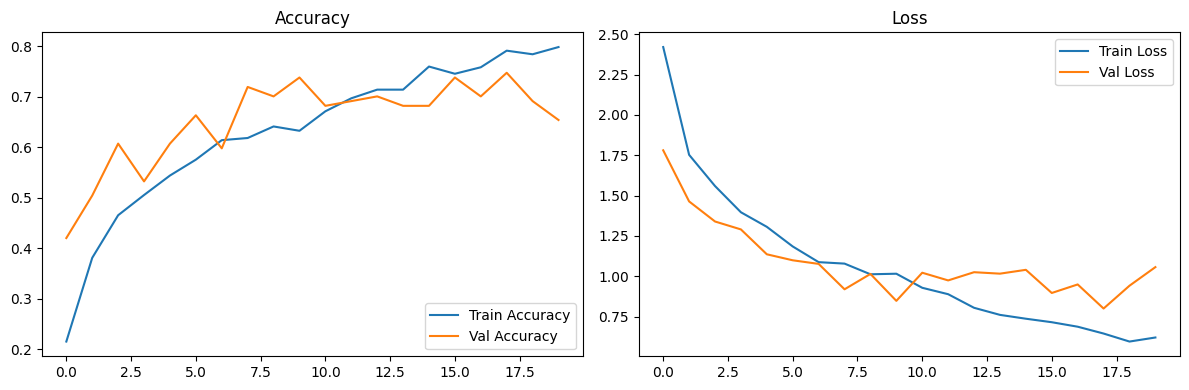

In [67]:
history = pd.read_csv("history/train_history_adam_lr0p001_drop0p3_units128.csv")
plot_history(history)


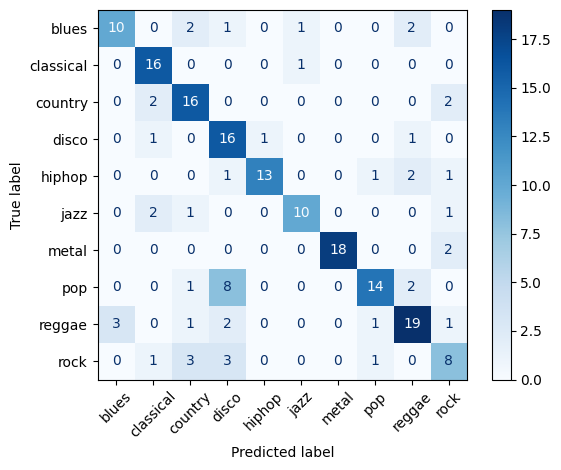

In [68]:
def plot_confusion_matrix(predictions):
    y_true = predictions["true_label"]
    y_pred = predictions["predicted_label"]

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_ds.class_names)
    disp.plot(cmap='Blues', xticks_rotation=45)
    plt.savefig("confusion_matrix.png")
    plt.show()

plot_confusion_matrix(pd.read_csv("predictions/pred_adam_lr0p001_drop0p3_units128.csv"))